### УПРАВЛЕНИЕ КРЕДИТНЫМ РИСКОМ

Этот блокнот Jupyter содержит все коды и выводы, которые были сделаны при работе над финальной задачей по управлению кредитным риском на платформе Skillbox.

### Автор : Умиджон Сатторов. Студент платформы Skillbox и младший инженер по машинному обучению.

In [ ]:
#Adding google drive to colab environment.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
#Importing necessary modules and libraries
#Data processing
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing and feature engineering
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

#Modelling
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

#Metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

#Saving machine learning model into pickle format
import dill as pkl

Важная информация о структуре датасета и особенностях:

1) id - Идентификатор приложения. Заявления нумеруются так, чтобы больший номер соответствовал более поздней дате подачи заявления.

2) рн – порядковый номер кредитного продукта в кредитной истории. Большее число соответствует продукту с более поздней датой открытия.

3) pre_since_opened - Дней от даты открытия кредита до даты сбора данных (в бинарной форме*)

4) pre_since_confirmed — количество дней с даты подтверждения информации о кредите до даты сбора данных (в бинарной форме*)

5) pre_pterm - Планируемое количество дней от даты открытия кредита до даты закрытия (в бинарной форме*)

6) pre_fterm — фактическое количество дней от даты открытия кредита до даты закрытия (в бинарном формате*)

7) pre_till_pclose - Планируемое количество дней от даты сбора данных до даты закрытия кредита (в бинарной форме*)

8) pre_till_fclose — фактическое количество дней с даты сбора данных до даты закрытия кредита (в бинарной форме*)

9) pre_loans_credit_limit - Кредитный лимит (в бинарной форме*)

10) pre_loans_next_pay_summ - Сумма следующего платежа по кредиту (в бинарной форме*)

11) pre_loans_outstanding — Оставшаяся сумма непогашенного кредита (в бинарной форме*)

12) pre_loans_total_overdue — Текущая просроченная задолженность (в бинарной форме*)

13) pre_loans_max_overdue_sum - Максимальная просроченная задолженность (в бинарной форме*)

14) pre_loans_credit_cost_rate — Общая стоимость кредита (в бинарной форме*)

15) pre_loans5 - Количество просрочек до 5 дней (в бинарной форме*)

16) pre_loans530 - Количество просрочек от 5 до 30 дней (в бинарной форме*)

17) pre_loans3060 - Количество просрочек от 30 до 60 дней (бинаризация*)

18) pre_loans6090 - Количество просрочек от 60 до 90 дней (бинаризация*)

19) pre_loans90 - Количество просрочек более 90 дней (в бинарной форме*)

20) is_zero_loans_5 - Флаг: отсутствие просрочек до 5 дней

21) is_zero_loans_530 - Флаг: нет просрочки от 5 до 30 дней

22) is_zero_loans_3060 - Флаг: нет просрочки от 30 до 60 дней

23) is_zero_loans_6090 - Флаг: нет просрочки от 60 до 90 дней

24) is_zero_loans90 - Флаг: нет просрочки более 90 дней.

25) pre_util - Отношение оставшейся неоплаченной суммы кредита к кредитному лимиту (в бинарной форме*)

26) pre_over2limit - Отношение текущей просроченной задолженности к кредитному лимиту (в бинарной форме*)

27) pre_maxover2limit - Отношение максимальной просроченной задолженности к кредитному лимиту (в бинарной форме*)

28) is_zero_util - Флаг: отношение оставшейся неоплаченной суммы кредита к кредитному лимиту равно 0

29) is_zero_over2limit - Флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0

30) is_zero_maxover2limit - Флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0

31) enc_paym_{0..N} - Статусы ежемесячных платежей за последние N месяцев (закодированы**)

32) enc_loans_account_holder_type - Тип кредитных отношений (закодировано**)

33) enc_loans_credit_status - Статус кредита (закодирован**)

34) enc_loans_account_cur - Валюта кредита (закодирована**)

35) enc_loans_credit_type - Тип кредита (закодирован**)

36) pclose_flag - Флаг: плановое количество дней от даты открытия кредита до даты закрытия не определено

37) fclose_flag - Флаг: фактическое количество дней от даты открытия кредита до даты закрытия не определено

* диапазон значений поля разбит на N непересекающихся интервалов, каждому интервалу случайным образом присваивается уникальный номер от 0 до N-1, значение поля заменяется на номер интервала, которому оно принадлежит

** каждому уникальному значению поля случайным образом присваивается уникальный номер от 0 до K, значение поля заменяется номером этого значения

In [ ]:
#Reading all of the data from the dataset providen
data = []
for i in range(0, 12, 1) :
    df_sample = pd.read_parquet(path = f'/content/drive/MyDrive/data/train_data_{i}.pq')
    data.append(df_sample)

df = pd.concat(data)
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [ ]:
df.duplicated().sum()

0

В наборе данных нет повторяющихся значений.

    Простой обзор данных

In [ ]:
#Sample Data Review
df[df['id'] == 0]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0
5,0,6,5,0,11,8,12,11,4,2,...,3,3,3,4,1,2,3,1,0,1
6,0,7,3,9,1,2,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
7,0,8,2,9,2,3,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
8,0,9,1,9,11,13,14,8,2,5,...,3,3,3,4,1,2,4,1,0,0
9,0,10,7,9,2,10,8,8,16,4,...,3,3,3,4,1,2,4,1,0,0


In [ ]:
#Sample Data Review
df[df['id'] == 1]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
10,1,1,8,7,12,15,9,1,1,2,...,0,3,3,4,1,3,4,1,0,0
11,1,2,8,7,13,2,9,1,6,2,...,3,3,3,4,1,3,4,1,0,0
12,1,3,15,7,7,6,9,1,6,2,...,3,3,3,4,1,3,4,1,0,0
13,1,4,15,3,7,6,9,1,6,2,...,3,3,3,4,1,3,1,1,0,0
14,1,5,14,4,7,6,9,1,3,2,...,0,1,0,1,1,3,4,1,0,0
15,1,6,14,14,1,0,13,13,0,2,...,3,3,3,4,1,3,4,1,0,0
16,1,7,14,3,8,11,6,13,6,2,...,3,3,3,4,1,3,1,1,0,0
17,1,8,10,14,2,14,13,5,14,0,...,0,0,0,1,1,3,4,1,0,0
18,1,9,10,14,15,9,13,3,10,2,...,3,3,3,4,1,3,4,1,0,0
19,1,10,13,6,0,1,14,8,16,4,...,0,0,0,1,1,2,3,1,0,0


In [ ]:
#Checking the size of the dataset
df.shape

(26162717, 61)

In [ ]:
#Checking empty values for every column
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

В наборе данных нет пустых значений, а размер набора данных чрезвычайно огромен. Это может создать проблемы с вычислениями и агрегацией, если мы не знаем структуру данных.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  is_z

Проверка распределения набора данных

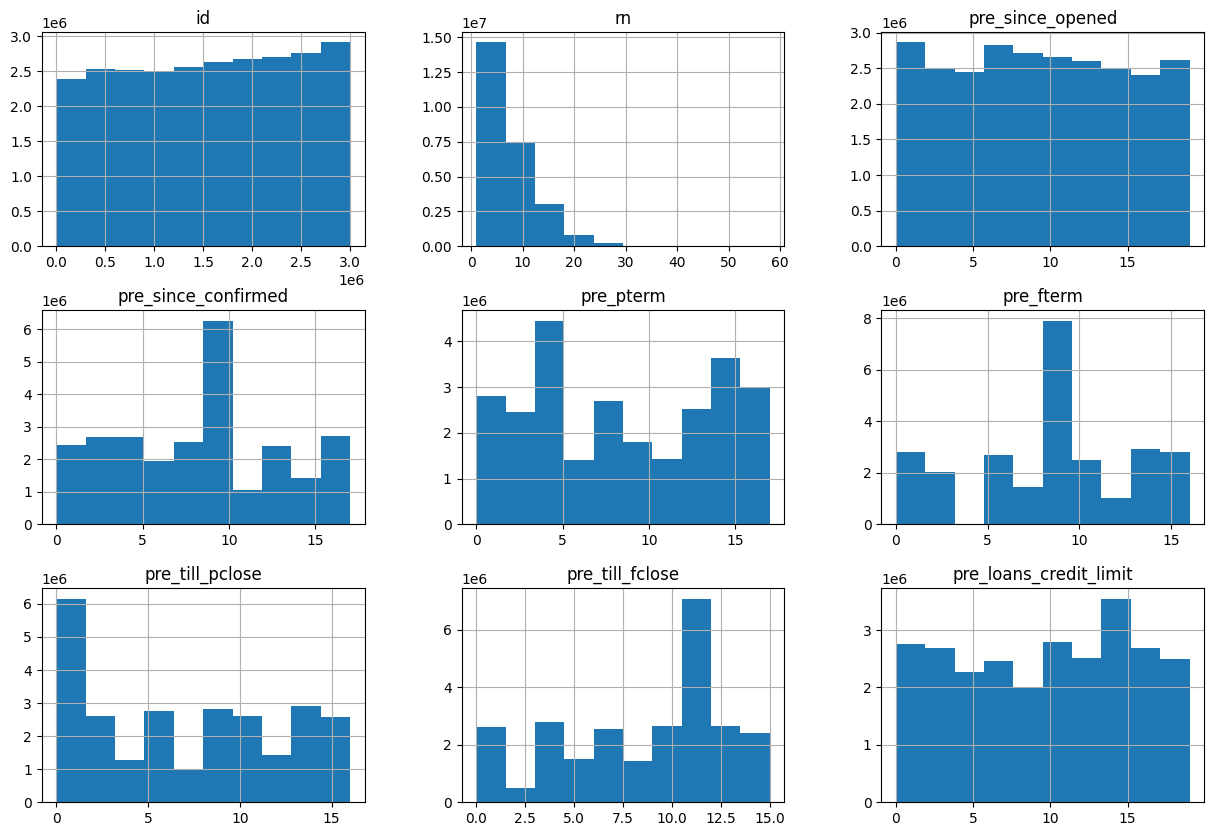

In [ ]:
#Distribution of the data in numerical features
df[['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit']].hist(figsize=(15, 10))
plt.show()

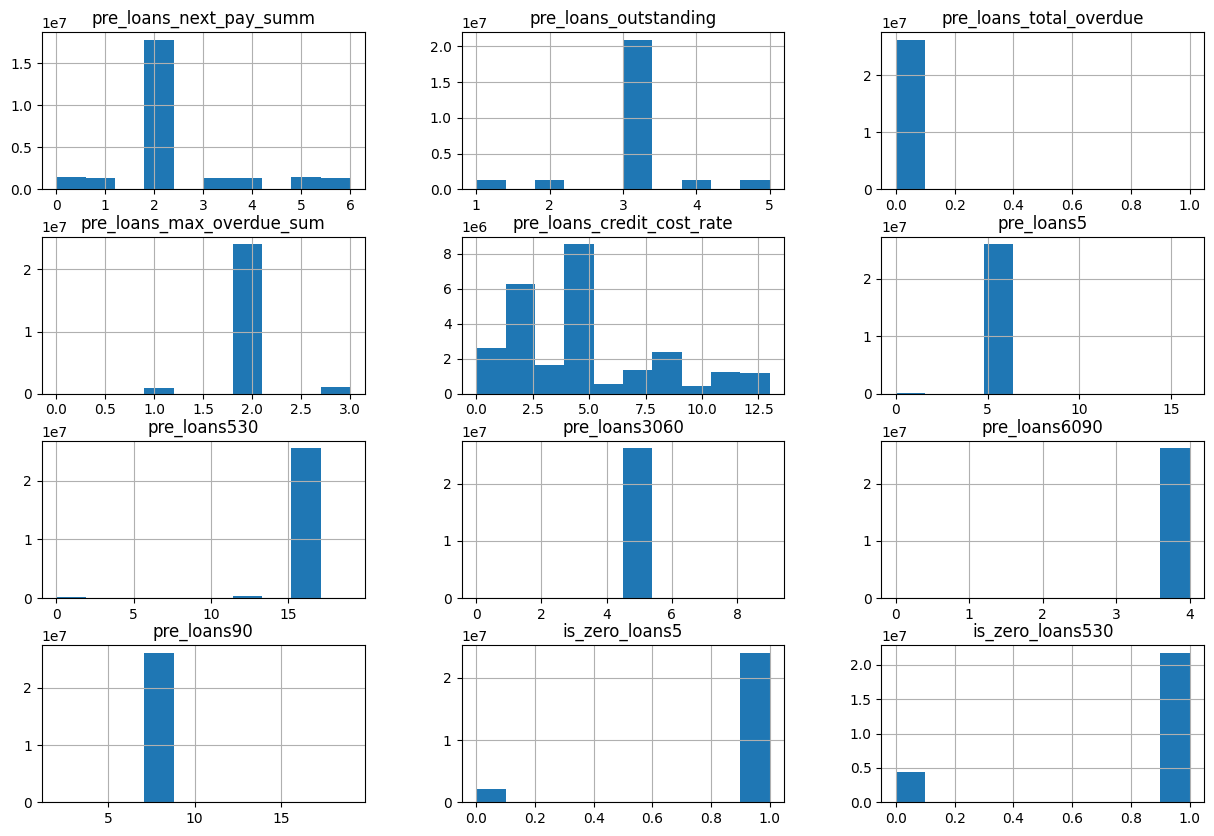

In [ ]:
#Distribution of the data in numerical features
df[['pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530']].hist(figsize=(15, 10))
plt.show()

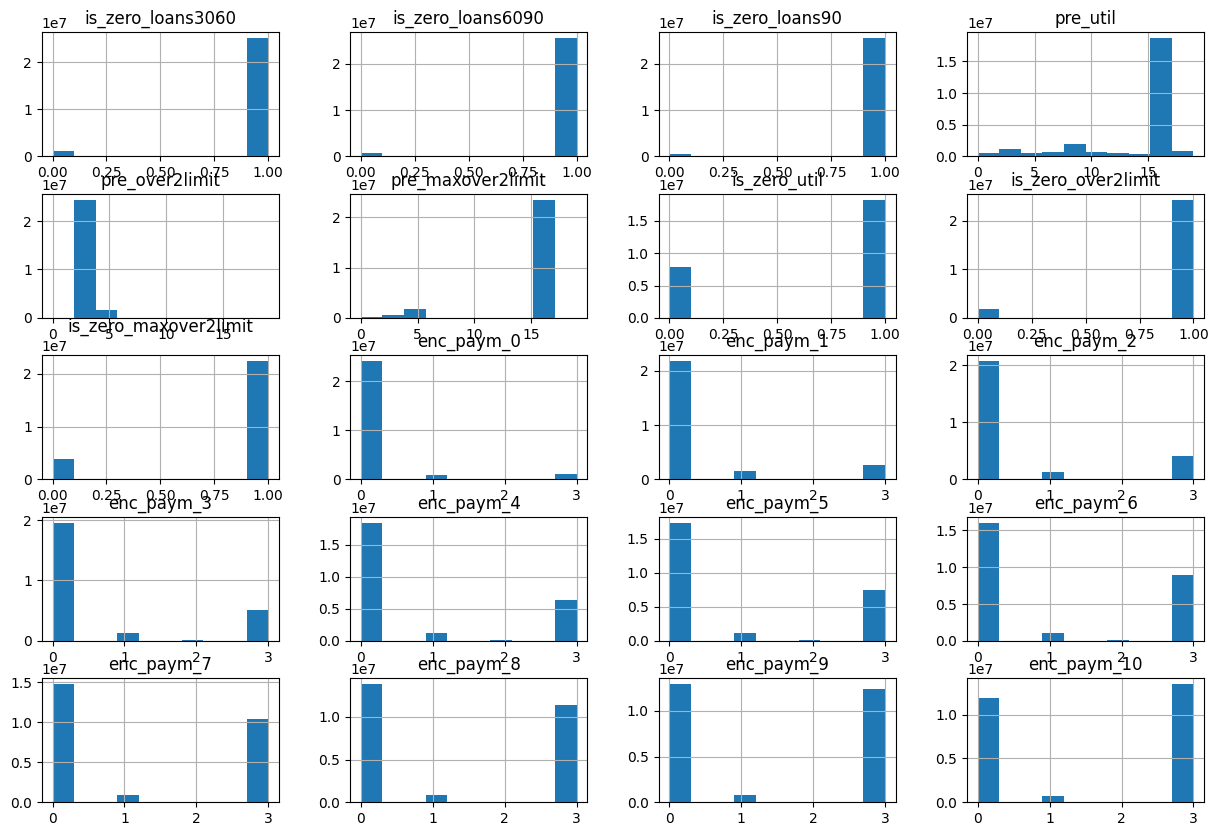

In [ ]:
#Distribution of the data in numerical features
df[['is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10']].hist(figsize=(15, 10))
plt.show()

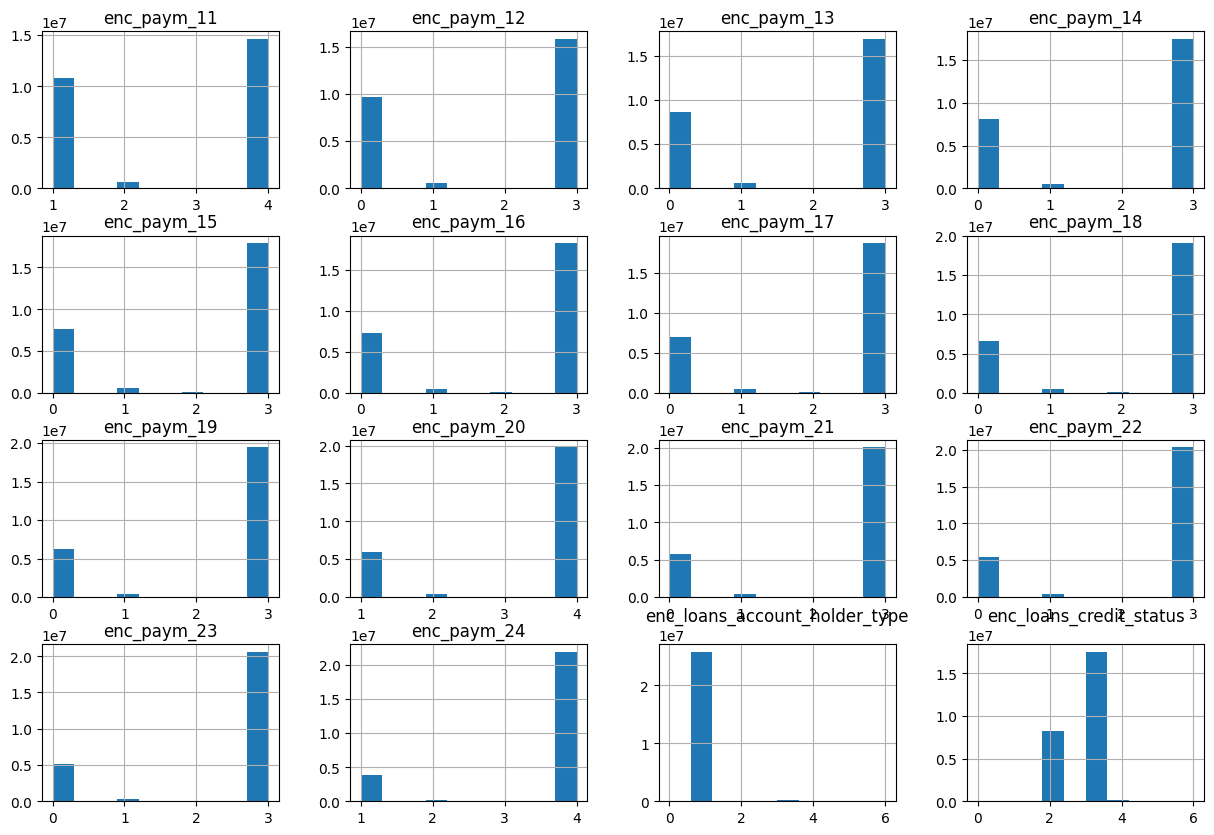

In [ ]:
#Distribution of the data in numerical features
df[['enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status']].hist(figsize=(15, 10))
plt.show()

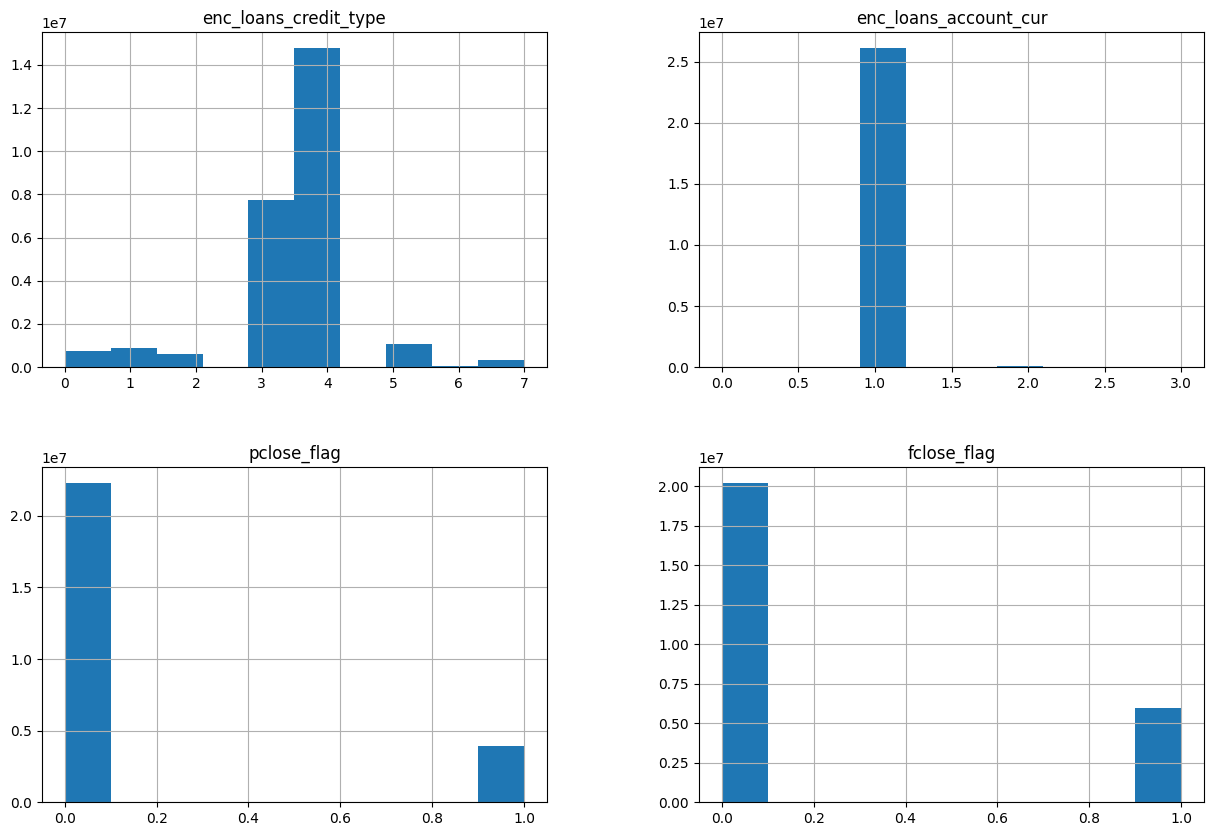

In [ ]:
#Distribution of the data in numerical features
df[['enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag', 'fclose_flag']].hist(figsize=(15, 10))
plt.show()

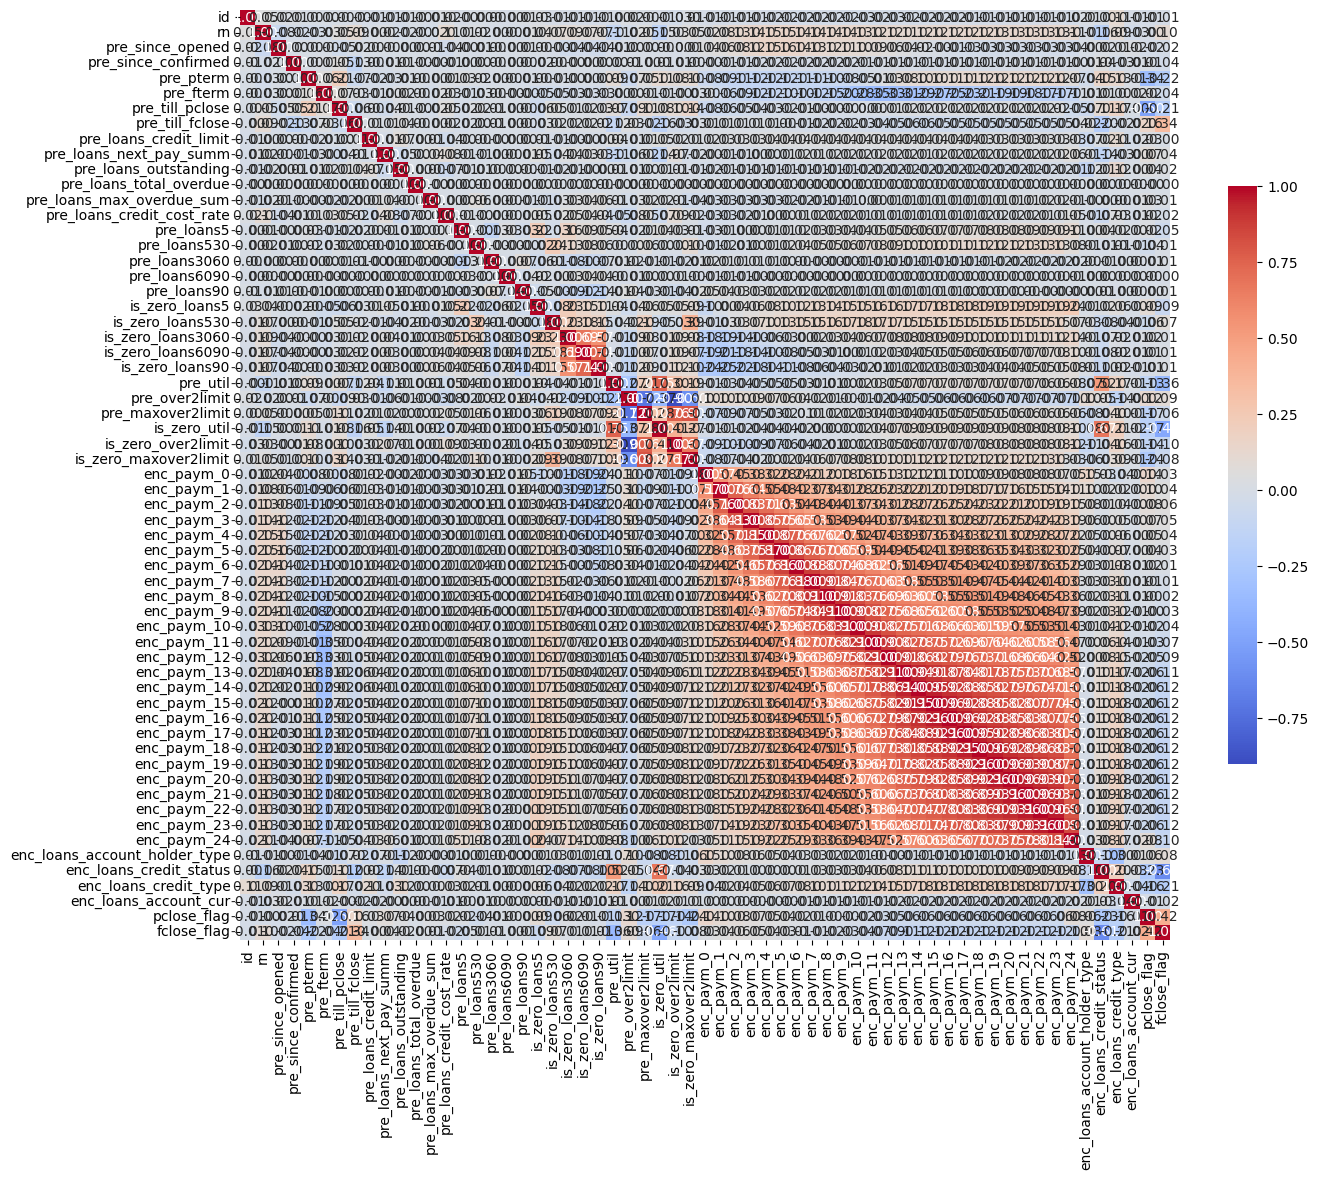

In [ ]:
#Correlation matrix of the features
corr_matrix = df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.show()

Из структуры значений для каждого столбца мы можем определенно сказать, что некоторые функции являются двоичными (флажковые функции), а некоторые функции закодированы (это категориальные функции, но закодированы числами. Я должен относиться к ним как к категориальным функциям и используйте кодировщик One Hot, прежде чем объединять мой набор данных в меньший.) У меня также есть функция в двоичном кодировании, которая обычно является категориальной функцией. Вот почему мне приходится относиться к ним как к категориальным признакам и кодировать их с помощью One Hot Encoder.

In [ ]:
coded_features = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
              'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14',
              'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
              'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status',
              'enc_loans_credit_type', 'enc_loans_account_cur']

binary_cols = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue',
               'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
               'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit','pre_maxover2limit']

flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
             'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag']

### Aggregation of the feature and normalization

In [ ]:
ohe_cols = binary_cols + coded_features
ohe = OneHotEncoder(min_frequency = 250, sparse_output = False, dtype = 'int8')

ohe.fit(df[ohe_cols])

batch_size = 100000

ohe_data_list = []

i = 1

for start in range(0, len(df), batch_size) :
    end = start + batch_size
    batch = df[ohe_cols].iloc[start : end]
    ohe_data_batch = ohe.transform(batch)
    ohe_data_list.append(ohe_data_batch)
    print(f'This cycle is in the {i} stage')
    i += 1
ohe_data = pd.DataFrame(np.concatenate(ohe_data_list, axis = 0), columns = ohe.get_feature_names_out(ohe_cols))
df = df.reset_index(drop = True).join(ohe_data).drop(columns = ohe_cols)
df.head()

This cycle is in the 1 stage
This cycle is in the 2 stage
This cycle is in the 3 stage
This cycle is in the 4 stage
This cycle is in the 5 stage
This cycle is in the 6 stage
This cycle is in the 7 stage
This cycle is in the 8 stage
This cycle is in the 9 stage
This cycle is in the 10 stage
This cycle is in the 11 stage
This cycle is in the 12 stage
This cycle is in the 13 stage
This cycle is in the 14 stage
This cycle is in the 15 stage
This cycle is in the 16 stage
This cycle is in the 17 stage
This cycle is in the 18 stage
This cycle is in the 19 stage
This cycle is in the 20 stage
This cycle is in the 21 stage
This cycle is in the 22 stage
This cycle is in the 23 stage
This cycle is in the 24 stage
This cycle is in the 25 stage
This cycle is in the 26 stage
This cycle is in the 27 stage
This cycle is in the 28 stage
This cycle is in the 29 stage
This cycle is in the 30 stage
This cycle is in the 31 stage
This cycle is in the 32 stage
This cycle is in the 33 stage
This cycle is in th

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,0,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
1,0,2,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
2,0,3,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0
3,0,4,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0,5,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
feature_names_list = ohe.get_feature_names_out().tolist()

output_file = '/content/drive/MyDrive/data/feature_names.txt'

with open(output_file, 'w') as f:
    for feature_name in feature_names_list:
        f.write(f"{feature_name}\n")

print(f"Feature names have been saved to {output_file}")

Feature names have been saved to /content/drive/MyDrive/data/feature_names.txt


In [ ]:
#Categorizing the features and keeping them after aggregating using sum() function
category_df = df.groupby(['id'], as_index=False)[ohe.get_feature_names_out()].sum()
flag_df = df.groupby(['id'], as_index=False)[flag_cols].mean()
rn_df = df.groupby(['id'], as_index=False)[['rn']].count()

df = pd.merge(left=rn_df, right=flag_df, on='id')
df = pd.merge(left=df, right=category_df, on='id')

Здесь, используя приведенный выше код, я сохранил категориальные функции, даже если в моем наборе данных происходит агрегирование. Для этой цели я использовал OneHotencoder.

Для функций флага я использовал функцию среднего значения, чтобы получить средние значения для функций флага.

Для функции rn я использовал функцию подсчета, чтобы получить количество сеансов, которые пользователь испытал, когда обратился в банк с целью получения кредита.

In [ ]:
#Removing unnecessary column of data from the dataset
df = df.drop(['id'], axis=1)
df

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,...,0,2,7,0,0,0,0,10,0,0
1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,...,0,3,8,0,0,0,0,14,0,0
2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,...,0,2,1,0,0,0,0,3,0,0
3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,...,0,4,9,1,0,0,0,15,0,0
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,11,0.818182,0.454545,1.000000,1.000000,1.000000,0.727273,1.000000,0.636364,0.181818,...,0,4,6,0,0,1,0,11,0,0
2999996,13,0.923077,1.000000,0.923077,1.000000,1.000000,0.692308,0.846154,0.846154,0.384615,...,0,4,8,0,0,1,0,13,0,0
2999997,10,0.900000,0.700000,1.000000,1.000000,1.000000,0.600000,1.000000,0.900000,0.100000,...,0,3,7,0,0,0,0,10,0,0
2999998,5,1.000000,1.000000,0.800000,0.800000,0.800000,0.200000,0.800000,0.800000,0.400000,...,0,2,2,0,0,0,0,5,0,0


Поскольку идентификатор столбца не имеет никакого значения для нашей проблемы, я только что решил удалить этот столбец из своего набора данных.

In [ ]:
#Reading and outputting dataframe with target variable
target_df = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/data/train_target.csv')
target_df.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
df['id'] = rn_df['id']
df.head()

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn,id
0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,...,2,7,0,0,0,0,10,0,0,0
1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,...,3,8,0,0,0,0,14,0,0,1
2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,...,2,1,0,0,0,0,3,0,0,2
3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,...,4,9,1,0,0,0,15,0,0,3
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,0,0,0,0,0,1,0,0,4


In [ ]:
#Adding target column to the dataframe
total_df = pd.merge(df, target_df, on='id', how='left')
total_df.head()

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn,id,flag
0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,...,7,0,0,0,0,10,0,0,0,0
1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,...,8,0,0,0,0,14,0,0,1,0
2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,...,1,0,0,0,0,3,0,0,2,0
3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,...,9,1,0,0,0,15,0,0,3,0
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,1,0,0,4,0


In [ ]:
#Saving dataframe in the csv format
total_df.to_csv(path_or_buf = '/content/drive/MyDrive/data/proper_data.csv')
print("Data is successfully saved")

Data is successfully saved


### Modelling

In [ ]:
#Reading dataframe from csv file
full_df = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/data/proper_data.csv', sep = ',')
full_df.head()

,Unnamed: 0,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn,id,flag
0,0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,...,7,0,0,0,0,10,0,0,0,0
1,1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,...,8,0,0,0,0,14,0,0,1,0
2,2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,...,1,0,0,0,0,3,0,0,2,0
3,3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,...,9,1,0,0,0,15,0,0,3,0
4,4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,1,0,0,4,0


Checking if the dataset is unbalanced or not

In [ ]:
#Checking if the dataset is unbalanced or not
full_df['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

Да, набор данных несбалансирован. Это может создать проблему для моей модели машинного обучения. Однако я могу использовать SMOTE и другие методы для решения этой проблемы. Если SMOTE не будет работать, я буду использовать присвоение весов, чтобы улучшить качество задачи классификации.

"""

Я попытался удалить выбросы из своего набора данных, но это отрицательно повлияло на качество моей модели. Я собираюсь пропустить этот этап моделирования.

"""

In [ ]:
#Dividing dataset into training and test sets
x = full_df.drop(columns = ['Unnamed: 0', 'flag'])
y = full_df['flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [ ]:
#Using smote for balancing dataset
os = SMOTE(random_state = 1)

x_train_resampled, y_train_resampled = os.fit_resample(X = x_train, y = y_train)
y_train_resampled.value_counts()

flag
0    2025486
1    2025486
Name: count, dtype: int64

In [ ]:
#Saving resampled dataframes into csv format
x_train_resampled.to_csv(path_or_buf = '/content/drive/MyDrive/data/x_train_resampled.csv')
y_train_resampled.to_csv(path_or_buf = '/content/drive/MyDrive/data/y_train_resampled.csv')
print("Data is successfully saved")

Data is successfully saved


In [ ]:
#Training Random Forest Classifier with default parameters
model = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state = 1)
model.fit(X = x_train_resampled, y = y_train_resampled)

print(f"The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])}")
print(f"The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])}")

The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) 0.6247673610509933
The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) 0.6258099285143941


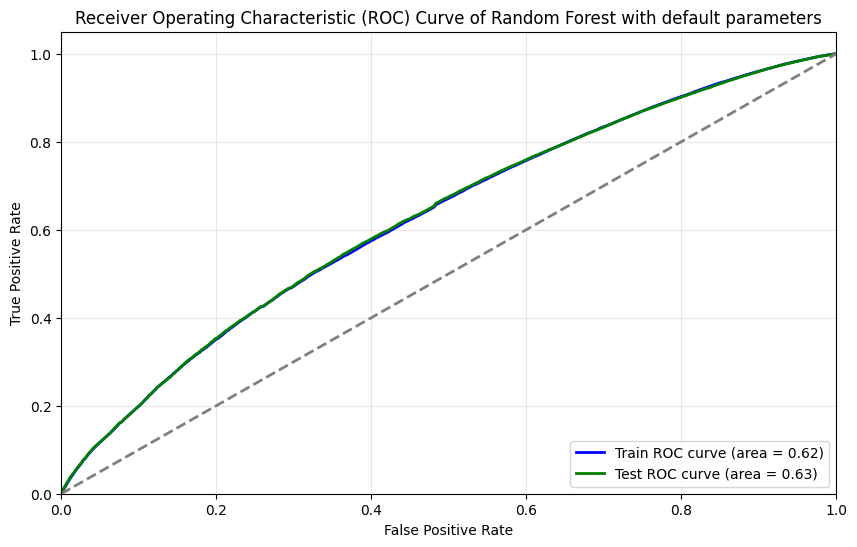

In [ ]:
#Drawing roc_auc line for seeing the models performance
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(x_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest with default parameters')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Поскольку поиск по сетке и случайный поиск требуют огромной вычислительной мощности, я подумал, что было бы лучше, если бы я использовал присвоение весов для обучения классификатора случайного леса, а не для поиска гиперпараметров для моей модели.

In [ ]:
#Calculating class weights
class_counts = y_train.value_counts().reset_index()
class_counts.columns = ['class', 'count']
class_counts['class_weight'] = len(y_train) / class_counts['count']

class_weights = class_counts.set_index('class')['class_weight'].to_dict()

In [ ]:
#Random forests with weight assignment
rm_weight = RandomForestClassifier(n_estimators = 50, max_depth = 8, random_state = 1, class_weight = class_weights, min_samples_split = 2, min_samples_leaf = 5)
rm_weight.fit(X = x_train, y = y_train)

print(f"The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) {roc_auc_score(y_train, rm_weight.predict_proba(x_train)[:, 1])}")
print(f"The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) {roc_auc_score(y_test, rm_weight.predict_proba(x_test)[:, 1])}")

The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) 0.7324318539553425
The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) 0.7282424524014914


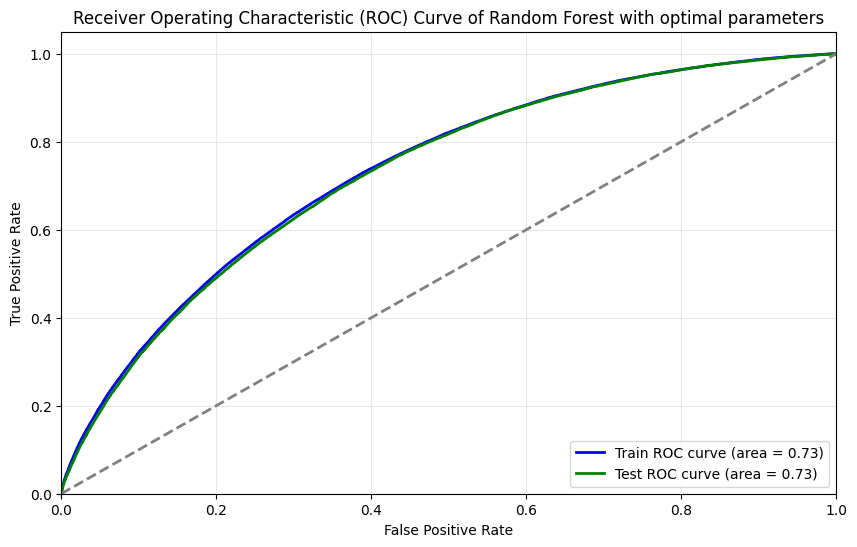

In [ ]:
#Drawing roc_auc line for seeing the models performance
fpr_train, tpr_train, _ = roc_curve(y_train, rm_weight.predict_proba(x_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, rm_weight.predict_proba(x_test)[:, 1])

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_score(y_train, rm_weight.predict_proba(x_train)[:, 1]):.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_score(y_test, rm_weight.predict_proba(x_test)[:, 1]):.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest with optimal parameters')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Поскольку поиск по сетке требовал от моего компьютера большей вычислительной мощности, я нашел оптимальные гиперпараметры вручную и достиг максимума в 69 баллов roc_auc с помощью алгоритмов случайных лесов с присвоением веса.

Здесь я попробую использовать StratifiedKFold и случайный выбор данных из основного класса, чтобы улучшить качество модели. Более того, я постараюсь использовать другие алгоритмы машинного обучения, чтобы увидеть улучшение прогноза.

### Using StratifiedKFlod

In [ ]:
kf = StratifiedGroupKFold(n_splits = 3, shuffle = True, random_state = 1)

models = []
metrics = []

for train_index, test_index in kf.split(X = x, y = y) :
    train_x, train_y = x.values[train_index], y.values[train_index]
    test_x, test_y = x.values[test_index], y.values[test_index]

    random_f = RandomForestClassifier(n_estimators = 50, max_depth = 8, random_state = 1, class_weight = class_weights, min_samples_split = 2, min_samples_leaf = 5)
    random_f.fit(train_x, train_y)
    score = roc_auc_score(y_test, random_f.predict_proba(x_test)[:, 1])
    print(score)

    models.append(random_f)
    metrics.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7325057135195056


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7322901657130912


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7322901657130912


### Using Cat Boost classifier algorithms for this problem

In [ ]:
sample_weights = np.array([class_weights[label] for label in y_train])

train_pool = Pool(data = x_train, label = y_train, weight = sample_weights)
train_not_weight = Pool(data = x_train, label = y_train)
test_pool = Pool(data = x_test, label = y_test)

cat_model = CatBoostClassifier(
       iterations=1500,
       learning_rate=0.1,
       depth=6,
       eval_metric='AUC',
       random_seed=1,
)

cat_model.fit(train_pool, eval_set = test_pool, early_stopping_rounds = 100)

#Evaluation of the model
train_predictions = cat_model.predict_proba(train_not_weight)[:, 1]
test_predictions = cat_model.predict_proba(test_pool)[:, 1]

train_auc_cat = roc_auc_score(y_train, train_predictions)
test_auc_cat = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of CatBoostClassifier (Train dataset): {train_auc_cat}")
print(f"The ROC AUC score of CatBoostClassifier (Test dataset): {test_auc_cat}")

0:	test: 0.6812273	best: 0.6812273 (0)	total: 216ms	remaining: 5m 24s
1:	test: 0.6941413	best: 0.6941413 (1)	total: 360ms	remaining: 4m 29s
2:	test: 0.7035965	best: 0.7035965 (2)	total: 518ms	remaining: 4m 18s
3:	test: 0.7130321	best: 0.7130321 (3)	total: 677ms	remaining: 4m 13s
4:	test: 0.7155702	best: 0.7155702 (4)	total: 833ms	remaining: 4m 8s
5:	test: 0.7172942	best: 0.7172942 (5)	total: 993ms	remaining: 4m 7s
6:	test: 0.7177960	best: 0.7177960 (6)	total: 1.14s	remaining: 4m 3s
7:	test: 0.7211656	best: 0.7211656 (7)	total: 1.3s	remaining: 4m 2s
8:	test: 0.7228403	best: 0.7228403 (8)	total: 1.46s	remaining: 4m 1s
9:	test: 0.7241521	best: 0.7241521 (9)	total: 1.61s	remaining: 4m
10:	test: 0.7256993	best: 0.7256993 (10)	total: 1.77s	remaining: 3m 59s
11:	test: 0.7272708	best: 0.7272708 (11)	total: 1.92s	remaining: 3m 57s
12:	test: 0.7282624	best: 0.7282624 (12)	total: 2.07s	remaining: 3m 56s
13:	test: 0.7290787	best: 0.7290787 (13)	total: 2.21s	remaining: 3m 55s
14:	test: 0.7306802	be

ВАУ, похоже, проблему можно решить с помощью алгоритма CatBoostClassifier (алгоритм, созданный компанией Яндекс на основе алгоритма повышения градиента). По результату, который мы получаем (roc_auc > 0,75), я могу с уверенностью сказать, что этот алгоритм можно использовать для прогнозирования, является ли пользователь банка мошенником или нет.

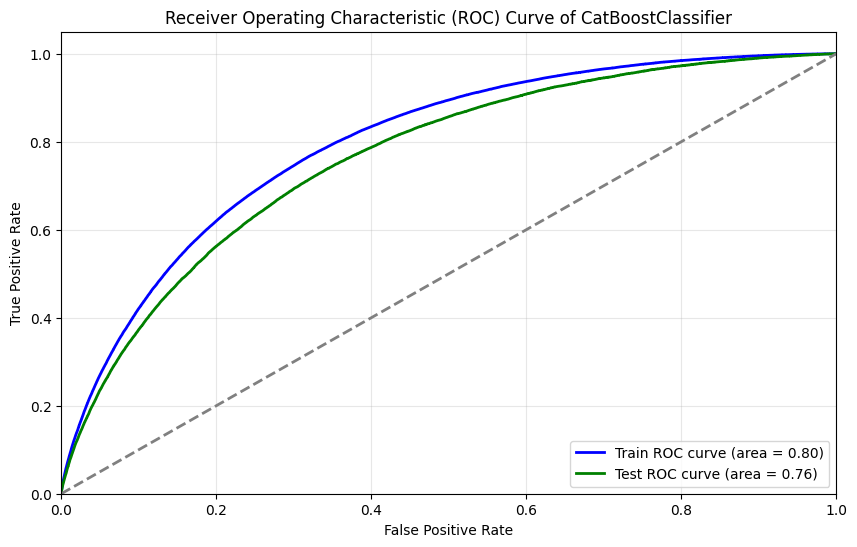

In [ ]:
#Drawing roc_auc line for seeing the models performance
fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {train_auc_cat:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {test_auc_cat:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of CatBoostClassifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
#Seeing the confusion matrix for given dataset
test_pred_labels = cat_model.predict(test_pool)

conf_matrix = confusion_matrix(y_test, test_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, test_pred_labels)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[604473 263599]
 [  9681  22247]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    868072
           1       0.08      0.70      0.14     31928

    accuracy                           0.70    900000
   macro avg       0.53      0.70      0.48    900000
weighted avg       0.95      0.70      0.79    900000



In [ ]:
#Checking important features from the dataset for catboostclassifier
feature_importances = cat_model.get_feature_importance(train_pool)
feature_names = x_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                      Feature  Importance
207                                pre_util_3    4.309527
2                            is_zero_loans530    3.834261
3                           is_zero_loans3060    3.453968
210                                pre_util_6    2.965648
378                   enc_loans_credit_type_0    2.721621
..                                        ...         ...
330                             enc_paym_16_2    0.000000
334                             enc_paym_17_2    0.000000
350                             enc_paym_21_2    0.000000
389  enc_loans_account_cur_infrequent_sklearn    0.000000
0                                          rn    0.000000

[391 rows x 2 columns]


In [ ]:
importance_df.head(100)

,Feature,Importance
207,pre_util_3,4.309527
2,is_zero_loans530,3.834261
3,is_zero_loans3060,3.453968
210,pre_util_6,2.965648
378,enc_loans_credit_type_0,2.721621
...,...,...
19,pre_since_opened_8,0.248179
137,pre_loans_next_pay_summ_0,0.247851
11,pre_since_opened_0,0.245990
140,pre_loans_next_pay_summ_3,0.245224


In [ ]:
#Keeping the top 100 features of the dataset and checking the performance of machine learning model with these features only
top_100_features = importance_df.head(100)['Feature'].tolist()
x_train_top_100 = x_train[top_100_features]
x_test_top_100 = x_test[top_100_features]

In [ ]:
#Saving top 100 cardinal features into csv format
importance_df.head(100).to_csv(path_or_buf = '/content/drive/MyDrive/data/top_100_features.csv')

In [ ]:
#Saving the end result in pickle format
pkl.dump(cat_model, open('/content/drive/MyDrive/data/cat_model_roc_auc_0.76.pkl', 'wb'))

In [ ]:
#Checking the performance of catboostclassifier algorithm with top 100 features
train_pool_top100 = Pool(data = x_train_top_100, label = y_train, weight = sample_weights)
test_pool_top100 = Pool(data = x_test_top_100, label = y_test)

cat_model_top100 = CatBoostClassifier(
       iterations=1500,
       learning_rate=0.1,
       depth=6,
       eval_metric='AUC',
       random_seed=1,
)

cat_model_top100.fit(train_pool_top100, eval_set = test_pool_top100, early_stopping_rounds = 100)

#Evaluation of the model
train_predictions = cat_model_top100.predict_proba(train_pool_top100)[:, 1]
test_predictions = cat_model_top100.predict_proba(test_pool_top100)[:, 1]

train_auc_cat = roc_auc_score(y_train, train_predictions)
test_auc_cat = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of CatBoostClassifier (Train dataset): {train_auc_cat}")
print(f"The ROC AUC score of CatBoostClassifier (Test dataset): {test_auc_cat}")

0:	test: 0.6810210	best: 0.6810210 (0)	total: 102ms	remaining: 2m 33s
1:	test: 0.6988212	best: 0.6988212 (1)	total: 210ms	remaining: 2m 37s
2:	test: 0.6995676	best: 0.6995676 (2)	total: 311ms	remaining: 2m 35s
3:	test: 0.7081343	best: 0.7081343 (3)	total: 412ms	remaining: 2m 34s
4:	test: 0.7167162	best: 0.7167162 (4)	total: 512ms	remaining: 2m 33s
5:	test: 0.7184045	best: 0.7184045 (5)	total: 622ms	remaining: 2m 34s
6:	test: 0.7202332	best: 0.7202332 (6)	total: 730ms	remaining: 2m 35s
7:	test: 0.7234191	best: 0.7234191 (7)	total: 833ms	remaining: 2m 35s
8:	test: 0.7251093	best: 0.7251093 (8)	total: 928ms	remaining: 2m 33s
9:	test: 0.7264472	best: 0.7264472 (9)	total: 1.03s	remaining: 2m 33s
10:	test: 0.7285566	best: 0.7285566 (10)	total: 1.14s	remaining: 2m 33s
11:	test: 0.7291986	best: 0.7291986 (11)	total: 1.24s	remaining: 2m 33s
12:	test: 0.7301856	best: 0.7301856 (12)	total: 1.34s	remaining: 2m 33s
13:	test: 0.7312717	best: 0.7312717 (13)	total: 1.44s	remaining: 2m 33s
14:	test: 0.

Даже с учетом 100 важнейших функций моя модель показала себя превосходно. Вот почему я думаю, что мне нужно использовать эти алгоритмы машинного обучения со 100 наиболее важными функциями для решения проблемы управления кредитным риском.

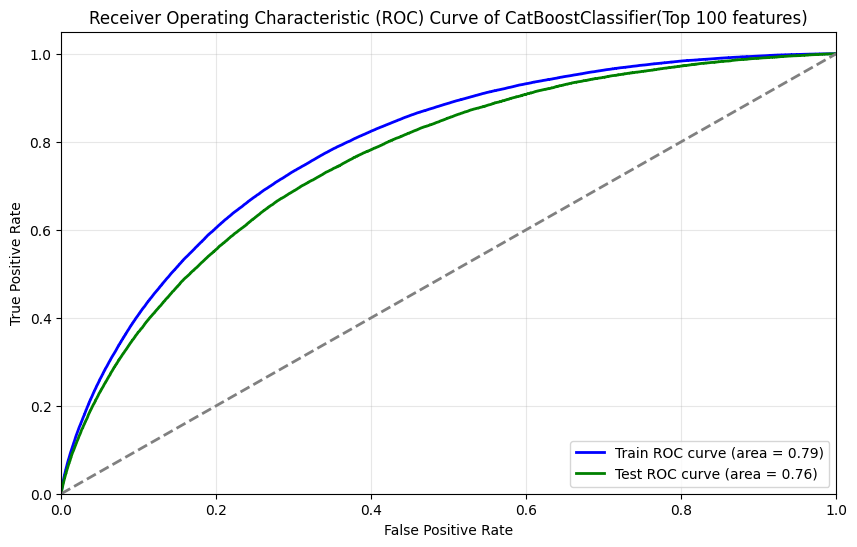

In [ ]:
#Drawing roc_auc line for seeing the models performance
fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {train_auc_cat:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {test_auc_cat:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of CatBoostClassifier(Top 100 features)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
#Seeing the confusion matrix for given dataset
test_pred_labels = cat_model_top100.predict(test_pool_top100)

conf_matrix = confusion_matrix(y_test, test_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, test_pred_labels)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[597937 270135]
 [  9565  22363]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    868072
           1       0.08      0.70      0.14     31928

    accuracy                           0.69    900000
   macro avg       0.53      0.69      0.47    900000
weighted avg       0.95      0.69      0.79    900000



###**Это последняя модель, которую я собираюсь сохранить и использовать**

In [ ]:
#Saving the end result in pickle format
pkl.dump(cat_model, open('/content/drive/MyDrive/data/cat_model_top_100.pkl', 'wb'))

### XGBoostClassifier for this problem

In [ ]:
import xgboost as xgb

train_dmatrix = xgb.DMatrix(data = x_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = x_test, label = y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 8,
    'seed': 1,
    'n_estimators': 1500
}


evals = [(train_dmatrix, 'train'), (test_dmatrix, 'eval')]
xgb_model = xgb.train(params, train_dmatrix, num_boost_round = 1500, evals = evals, early_stopping_rounds = 100)

train_predictions = xgb_model.predict(train_dmatrix)
test_predictions = xgb_model.predict(test_dmatrix)

train_auc_xgb = roc_auc_score(y_train, train_predictions)
test_auc_xgb = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of XGBoost (Train dataset): {train_auc_xgb}")
print(f"The ROC AUC score of XGBoost (Test dataset): {test_auc_xgb}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:11:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.70910	eval-auc:0.70574
[1]	train-auc:0.71202	eval-auc:0.70885
[2]	train-auc:0.71705	eval-auc:0.71346
[3]	train-auc:0.72266	eval-auc:0.71854
[4]	train-auc:0.72521	eval-auc:0.72089
[5]	train-auc:0.72718	eval-auc:0.72225
[6]	train-auc:0.72877	eval-auc:0.72350
[7]	train-auc:0.73061	eval-auc:0.72511
[8]	train-auc:0.73231	eval-auc:0.72624
[9]	train-auc:0.73403	eval-auc:0.72751
[10]	train-auc:0.73560	eval-auc:0.72853
[11]	train-auc:0.73852	eval-auc:0.73093
[12]	train-auc:0.74026	eval-auc:0.73230
[13]	train-auc:0.74165	eval-auc:0.73306
[14]	train-auc:0.74381	eval-auc:0.73458
[15]	train-auc:0.74594	eval-auc:0.73590
[16]	train-auc:0.74724	eval-auc:0.73699
[17]	train-auc:0.74885	eval-auc:0.73794
[18]	train-auc:0.75029	eval-auc:0.73884
[19]	train-auc:0.75166	eval-auc:0.73975
[20]	train-auc:0.75320	eval-auc:0.74080
[21]	train-auc:0.75461	eval-auc:0.74159
[22]	train-auc:0.75604	eval-auc:0.74250
[23]	train-auc:0.75739	eval-auc:0.74318
[24]	train-auc:0.75884	eval-auc:0.74407
[25]	train

**Алгоритм xgboost даже хорошо справился с нашей задачей. Он вернул показатель roc_auc 0,85 для нашего набора данных поездов и немного плохой для тестового набора данных с показателем 0,76 roc_auc. Но это может быть переобучение, поскольку разница между оценкой roc_auc в наборе данных поезда и тестовом наборе данных выше, чем оценка CatBoostClassifier. Вот почему я выбрал классификатор CatBoost, а не классификатор xgboost.**

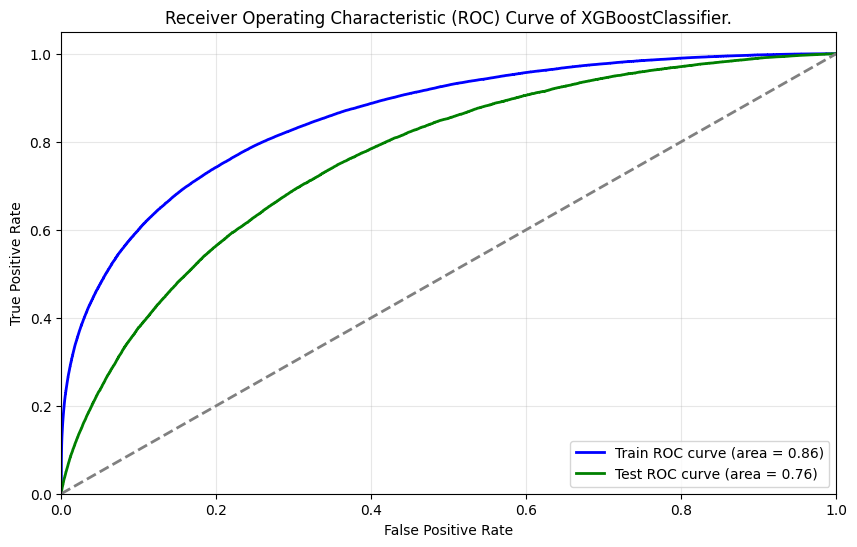

In [ ]:
#Drawing roc_auc line for seeing the models performance
fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {train_auc_xgb:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {test_auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of XGBoostClassifier.')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Using Logistic regression Classifier algorithm

The ROC AUC score of Logistic Regression (Train dataset): 0.5614659394358015
The ROC AUC score of Logistic Regression (Test dataset): 0.5603357773217605


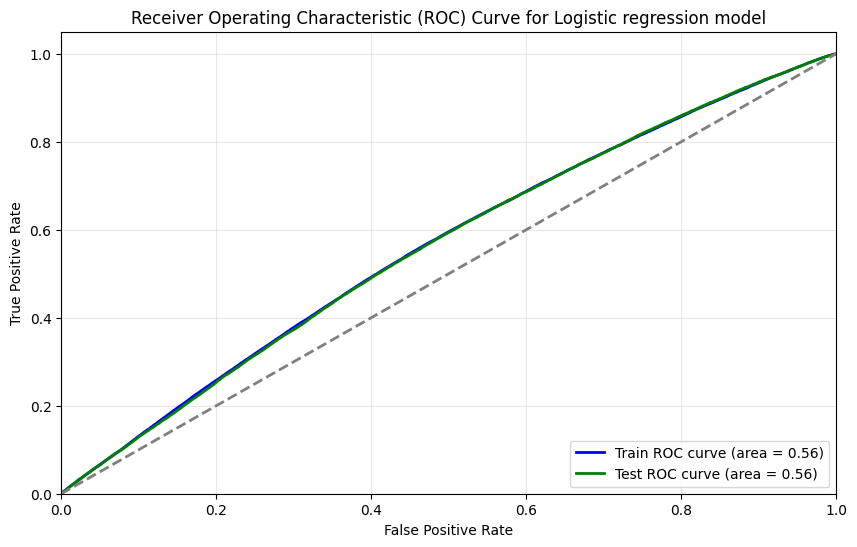

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1500, C = 1, random_state = 1, class_weight = class_weights)
log_reg.fit(x_train, y_train)


train_predictions = log_reg.predict_proba(x_train)[:, 1]
test_predictions = log_reg.predict_proba(x_test)[:, 1]

train_auc_log = roc_auc_score(y_train, train_predictions)
test_auc_log = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of Logistic Regression (Train dataset): {train_auc_log}")
print(f"The ROC AUC score of Logistic Regression (Test dataset): {test_auc_log}")

fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)

fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw = 2, label = f'Train ROC curve (area = {train_auc_log:.2f})')
plt.plot(fpr_test, tpr_test, color = 'green', lw=2, label = f'Test ROC curve (area = {test_auc_log:.2f})')

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic regression model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Судя по оценкам и графику roc_auc, я могу с уверенностью сказать, что логистическая регрессия не очень хорошо справляется с этой задачей.
Вот почему я не собираюсь использовать этот алгоритм для этой задачи.

### Using Ada Boost classifier algorithm

Little information about AdaBoostClassifier algorithm

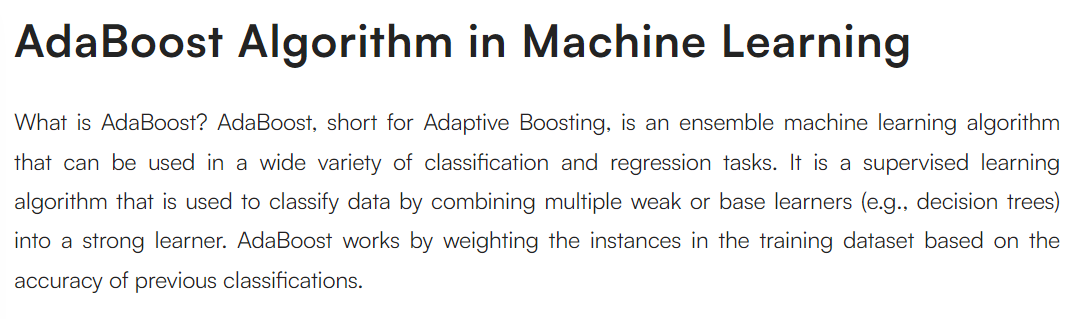

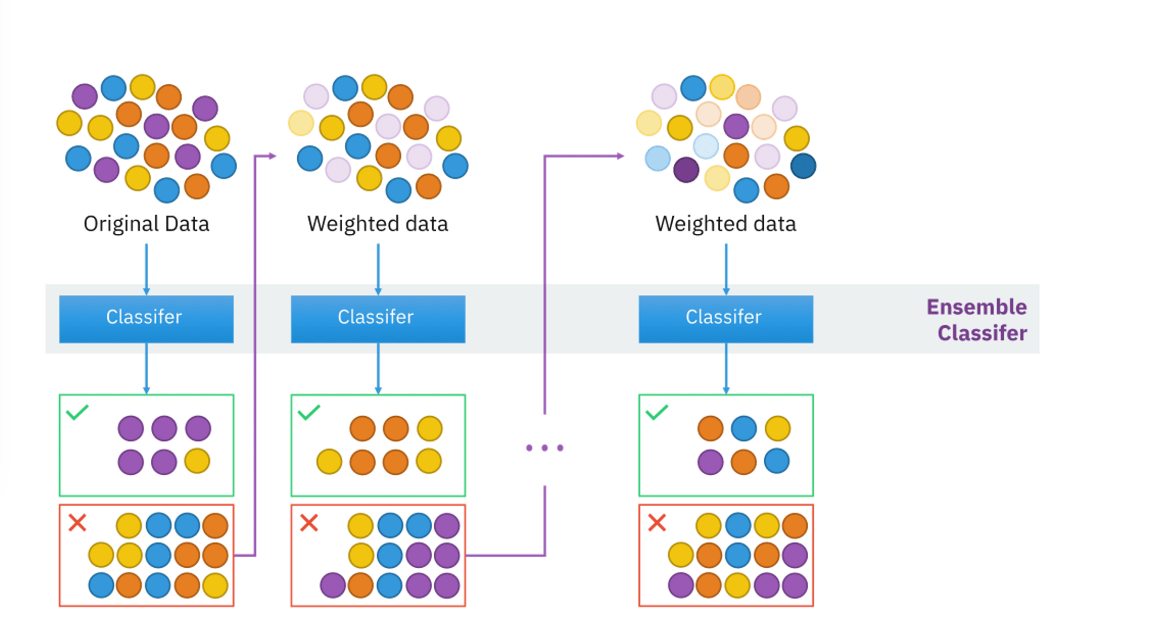

The ROC AUC score of AdaBoost (Train dataset): 0.7271314726364635
The ROC AUC score of AdaBoost (Test dataset): 0.7280566447943948


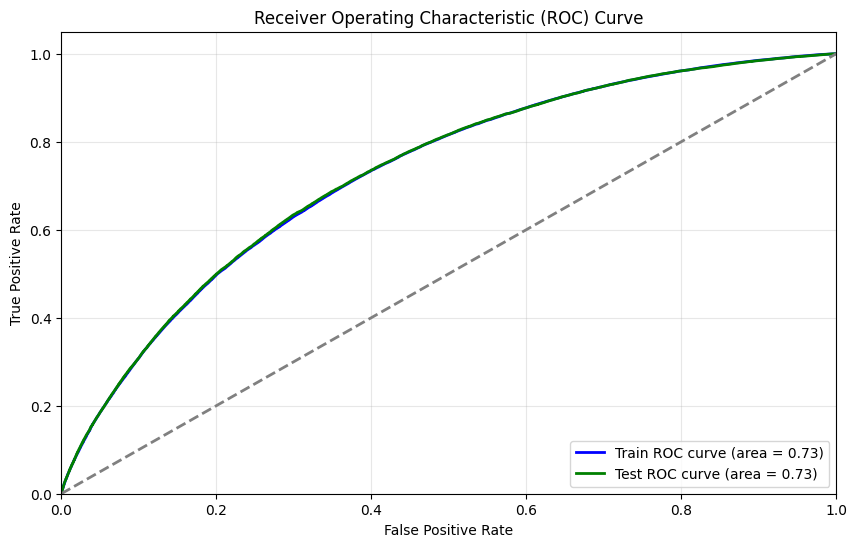

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

adaboost = AdaBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    random_state = 1
)

adaboost.fit(x_train, y_train)

train_predictions = adaboost.predict_proba(x_train)[:, 1]
test_predictions = adaboost.predict_proba(x_test)[:, 1]

train_auc_ada = roc_auc_score(y_train, train_predictions)
test_auc_ada = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of AdaBoost (Train dataset): {train_auc_ada}")
print(f"The ROC AUC score of AdaBoost (Test dataset): {test_auc_ada}")

# Step 6: Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)

fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {train_auc_ada:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {test_auc_ada:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


Хорошо, адаптивный классификатор повышения не работает должным образом и перенастроил максимальный показатель roc_auc 0,73. Вот почему я не собираюсь использовать эту модель для решения этой задачи.

###**Использование многослойного персептрона для нашей задачи классификации**

The ROC AUC score of MLP (Train dataset): 0.5000478664052551
The ROC AUC score of MLP (Test dataset): 0.5000473747056405


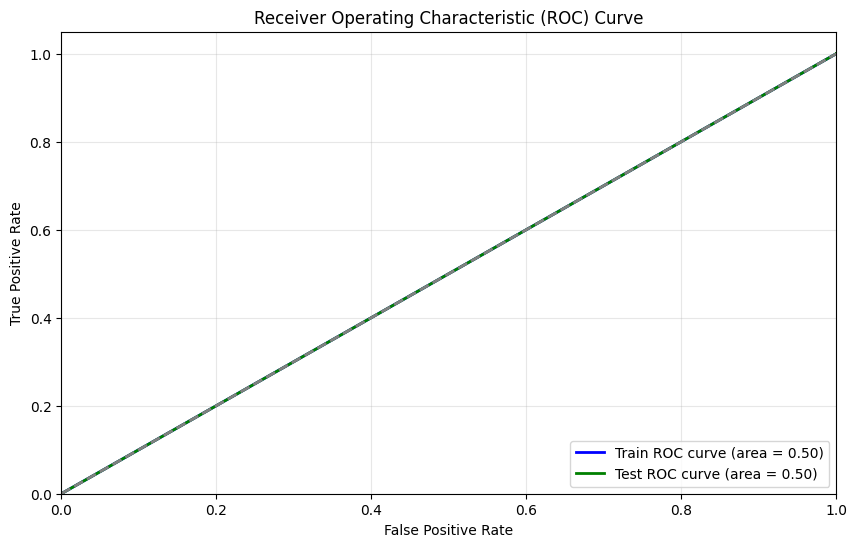

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes = (100),
    activation = 'relu',
    solver = 'adam',
    learning_rate_init = 0.001,
    max_iter = 200,
    random_state = 1
)

mlp.fit(x_train, y_train)

train_predictions = mlp.predict_proba(x_train)[:, 1]
test_predictions = mlp.predict_proba(x_test)[:, 1]

train_auc_mlp = roc_auc_score(y_train, train_predictions)
test_auc_mlp = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of MLP (Train dataset): {train_auc_mlp}")
print(f"The ROC AUC score of MLP (Test dataset): {test_auc_mlp}")

fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {train_auc_mlp:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {test_auc_mlp:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


Ого, многослойный перцептрон не очень хорошо работает с моим набором данных.

**Я видел ряд моделей классификации, таких как случайные леса, классификатор MLP, классификатор Adaptive Boost и логистическая регрессия. Среди них классификатор CatBoost показал хорошие результаты и дал оценку roc_auc выше 0,76. Модель не переобучена, поскольку разница между показателем roc_auc в наборе обучающих данных и наборе тестовых данных невелика. Я сохранил модель и создал конвейер в папке конвейера, используя эту модель.**